In [1]:
import random
from collections import Counter
from multiprocessing import Pool, cpu_count
from typing import Dict, List, Set, Tuple

import networkx as nx
import numpy as np
import pandas as pd

from icm_diffusion import simulate_diffusion_ICM
from src.graph import (
    create_polarized_graph,
    graph_loader,
    random_color_graph,
    spectral_bipartition_coloring,
    spectral_partition_coloring,
    k_means_partition_coloring
)
from src.seed import seed_degree, seed_mia, seed_polarized, seed_random


/Users/quenzer/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from edge_addition import (
    edge_addition_custom,
    edge_addition_adamic_adar,
    edge_addition_preferential_attachment,
    edge_addition_jaccard,
    edge_addition_degree,
    edge_addition_topk,
    edge_addition_prob,
    edge_addition_kkt,
    edge_addition_random,
)

In [3]:
# Function to evaluate and compare the graph modifications

def evaluate_graph_modifications(G, seeds, k, max_iter, budget):
    # Simulate diffusion on the original graph
    original_results_dict = simulate_diffusion_ICM(G, seeds, max_iter)

    # Extract original results
    original_results = pd.DataFrame(
        {
            "Metric": [
                "Avg Activated Nodes",
                "Activated Nodes Std Dev",
                "Avg Color Activation Count",
                "Color Activation Count Std Dev",
                "Edge-based Polarization",
                "Modularity-based Polarization",
                "Homophily-based Polarization",
            ],
            "Original Graph": [
                round(original_results_dict["avg_activated_nodes"], 3),
                round(original_results_dict["std_dev_activated_nodes"], 3),
                round(original_results_dict["avg_color_activation_count"], 3),
                round(original_results_dict["std_dev_color_activation_count"], 3),
                round(original_results_dict["polarization_scores"]["edge_based_polarization"], 3),
                round(original_results_dict["polarization_scores"]["modularity_based_polarization"], 3),
                round(original_results_dict["polarization_scores"]["homophily_based_polarization"], 3),
            ],
        }
    )

    # Get the number of nodes and edges for all graphs
    graph_info = {
        "Metric": ["Number of Nodes", "Number of Edges"],
        "Original Graph": [G.number_of_nodes(), G.number_of_edges()],
    }

    # Define a list of modification functions
    modification_functions = {
        "PrefAtt": edge_addition_preferential_attachment,
        "Jaccard": edge_addition_jaccard,
        "Degree": edge_addition_degree,
        "TopK": edge_addition_topk,
        "Prob": edge_addition_prob,
        "KKT": edge_addition_kkt,
        "Random": edge_addition_random,
        "Custom": edge_addition_custom,
    }

    combined_results = original_results.copy()

    # Evaluate each graph modification
    for method_name, mod_func in modification_functions.items():
        modified_graph = mod_func(G, seeds, k, budget)
        modified_results_dict = simulate_diffusion_ICM(modified_graph, seeds, max_iter)

        adapted_results = pd.DataFrame(
            {
                "Metric": [
                    "Avg Activated Nodes",
                    "Activated Nodes Std Dev",
                    "Avg Color Activation Count",
                    "Color Activation Count Std Dev",
                    "Edge-based Polarization",
                    "Modularity-based Polarization",
                    "Homophily-based Polarization",
                ],
                f"Adapted Graph {method_name}": [
                    round(modified_results_dict["avg_activated_nodes"], 3),
                    round(modified_results_dict["std_dev_activated_nodes"], 3),
                    round(modified_results_dict["avg_color_activation_count"], 3),
                    round(modified_results_dict["std_dev_color_activation_count"], 3),
                    round(modified_results_dict["polarization_scores"]["edge_based_polarization"], 3),
                    round(modified_results_dict["polarization_scores"]["modularity_based_polarization"], 3),
                    round(modified_results_dict["polarization_scores"]["homophily_based_polarization"], 3),
                ],
            }
        )

        combined_results = pd.merge(combined_results, adapted_results, on="Metric")
        graph_info[f"Adapted Graph {method_name}"] = [
            modified_graph.number_of_nodes(),
            modified_graph.number_of_edges(),
        ]

    graph_info_df = pd.DataFrame(graph_info)

    # Combine all results into one DataFrame
    final_results = pd.concat([graph_info_df, combined_results], ignore_index=True)

    # Transpose the DataFrame and set the first row as the header
    final_results = final_results.T
    final_results.columns = final_results.iloc[
        0
    ]  # Set the first row as the column names
    final_results = final_results.drop(final_results.index[0])  # Drop the first row

    return final_results


In [4]:
#G = create_polarized_graph(1000, 0.2, 0.01)
G = graph_loader("datasets/facebook/facebook_combined.txt")
#G = graph_loader('datasets/congress_network/congress.edgelist')
#color the graph
spectral_bipartition_coloring(G)
color_map = ['blue' if G.nodes[node]["color"] == 1 else 'red' for node in G.nodes()]
print(Counter(color_map))

Number of Nodes: 4039
Number of Edges: 88234


/Users/quenzer/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


Counter({'red': 3978, 'blue': 61})


In [5]:
seed_size = 50
k = seed_size
max_iter = 1000
budget = 3 * seed_size

In [6]:
seed = seed_mia(G, seed_size)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
final_results

100%|██████████| 1000/1000 [00:19<00:00, 51.14it/s]


Metric,Number of Nodes,Number of Edges,Avg Activated Nodes,Activated Nodes Std Dev,Avg Color Activation Count,Color Activation Count Std Dev,Edge-based Polarization,Modularity-based Polarization,Homophily-based Polarization
Original Graph,4039.0,88234.0,3085.528,163.273,0.12,0.374,0.0,0.0,0.0
Adapted Graph PrefAtt,4039.0,88384.0,3089.908,160.322,0.237,0.505,0.0,0.0,0.0
Adapted Graph Jaccard,4039.0,88384.0,3097.955,163.532,2.099,1.294,0.0,0.0,0.0
Adapted Graph Degree,4039.0,88384.0,3147.659,139.048,0.814,0.921,0.0,0.0,0.0
Adapted Graph TopK,4039.0,88384.0,3081.018,161.637,0.19,0.484,0.0,0.0,0.0
Adapted Graph Prob,4039.0,88384.0,3124.283,149.987,3.399,1.219,0.0,0.0,0.0
Adapted Graph KKT,4039.0,88384.0,3084.532,161.105,0.283,0.526,0.0,0.0,0.0
Adapted Graph Random,4039.0,88384.0,3102.164,155.471,0.769,0.824,0.0,0.0,0.0
Adapted Graph Custom,4039.0,88384.0,3086.625,158.009,50.346,6.679,0.002,0.0,0.001


In [7]:
seed = seed_polarized(G, seed_size, 0)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
final_results

100%|██████████| 1000/1000 [00:05<00:00, 191.76it/s]


Metric,Number of Nodes,Number of Edges,Avg Activated Nodes,Activated Nodes Std Dev,Avg Color Activation Count,Color Activation Count Std Dev,Edge-based Polarization,Modularity-based Polarization,Homophily-based Polarization
Original Graph,4039.0,88234.0,870.799,203.309,0.001,0.032,0.0,0.0,0.0
Adapted Graph PrefAtt,4039.0,88384.0,940.922,214.738,0.0,0.0,0.0,0.0,0.0
Adapted Graph Jaccard,4039.0,88384.0,1189.56,210.267,0.013,0.113,0.0,0.0,0.0
Adapted Graph Degree,4039.0,88384.0,2832.88,170.803,0.467,1.253,0.0,0.0,0.0
Adapted Graph TopK,4039.0,88384.0,869.221,199.97,0.0,0.0,0.0,0.0,0.0
Adapted Graph Prob,4039.0,88384.0,1280.015,255.242,0.285,0.469,0.0,0.0,0.0
Adapted Graph KKT,4039.0,88384.0,2784.419,188.651,0.4,0.983,0.0,0.0,0.0
Adapted Graph Random,4039.0,88384.0,1089.282,249.646,0.0,0.0,0.0,0.0,0.0
Adapted Graph Custom,4039.0,88384.0,921.718,196.541,50.981,8.059,0.002,0.0,0.003


In [8]:
seed = seed_random(G, seed_size)
final_results = evaluate_graph_modifications(G, seed, k, max_iter, budget)
final_results

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 406.55it/s]


Metric,Number of Nodes,Number of Edges,Avg Activated Nodes,Activated Nodes Std Dev,Avg Color Activation Count,Color Activation Count Std Dev,Edge-based Polarization,Modularity-based Polarization,Homophily-based Polarization
Original Graph,4039.0,88234.0,283.474,169.666,0.009,0.094,0.0,0.0,0.0
Adapted Graph PrefAtt,4039.0,88384.0,383.956,225.558,0.012,0.109,0.0,0.0,0.0
Adapted Graph Jaccard,4039.0,88384.0,834.113,204.849,0.352,0.49,0.0,0.0,0.0
Adapted Graph Degree,4039.0,88384.0,2786.336,181.652,0.524,1.329,0.0,0.0,0.0
Adapted Graph TopK,4039.0,88384.0,283.611,185.752,0.008,0.089,0.0,0.0,0.0
Adapted Graph Prob,4039.0,88384.0,785.162,271.907,3.034,0.212,0.0,0.0,0.0
Adapted Graph KKT,4039.0,88384.0,2528.31,229.772,0.904,2.369,0.0,0.0,0.0
Adapted Graph Random,4039.0,88384.0,505.593,226.116,0.22,0.464,0.0,0.0,0.0
Adapted Graph Custom,4039.0,88384.0,334.722,170.956,49.25,10.571,0.002,0.0,0.005


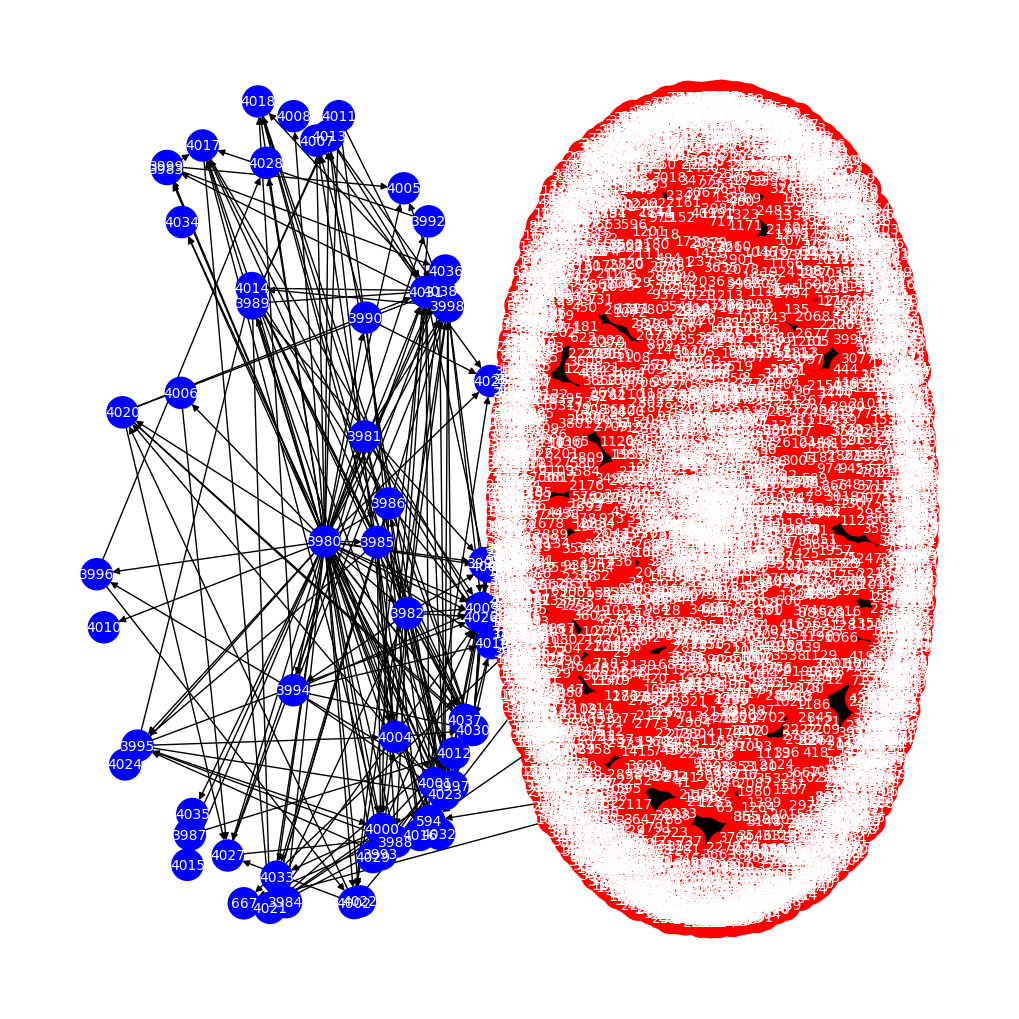

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_colored_graph(G):
    # Get colors for each node based on the 'color' attribute
    color_map = ['blue' if G.nodes[node]["color"] == 1 else 'red' for node in G.nodes()]
    
    # Create a layout that encourages nodes of the same color to be closer together
    pos = nx.spring_layout(G, k=0.3, seed=42)  # Adjust 'k' to control the spacing between groups
    
    # Separate positions based on color groups to manually adjust positions
    for node, (x, y) in pos.items():
        if G.nodes[node]["color"] == 1:
            pos[node] = (x - 1, y)  # Move blue nodes to the left
        else:
            pos[node] = (x + 1, y)  # Move red nodes to the right
    
    # Draw the graph
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_color=color_map, with_labels=True, node_size=500, font_color='white', font_size=10)
    
    # Display the graph
    plt.show()


draw_colored_graph(G)